In [1]:
from datetime import datetime
from functools import partial
import glob
from multiprocessing import Pool

# Disable multiprocesing for numpy/opencv. We already multiprocess ourselves, this would mean every subprocess produces
# even more threads which would lead to a lot of context switching, slowing things down a lot.
import os
os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import cv2
from PIL import Image
import numpy as np
from tqdm import tqdm, tqdm_notebook
import scipy
import scipy.ndimage
import scipy.special
from scipy.spatial.transform import Rotation as R

from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

train_data_folder = "/home/vignesh/workspace/lyft_3d/data/proper/artifacts/bev_train_data/"
validation_data_folder = "/home/vignesh/workspace/lyft_3d/data/proper/artifacts/bev_validation_data/"

classes = ["car", "motorcycle", "bus", "bicycle", "truck", "pedestrian", "other_vehicle", "animal", "emergency_vehicle"]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


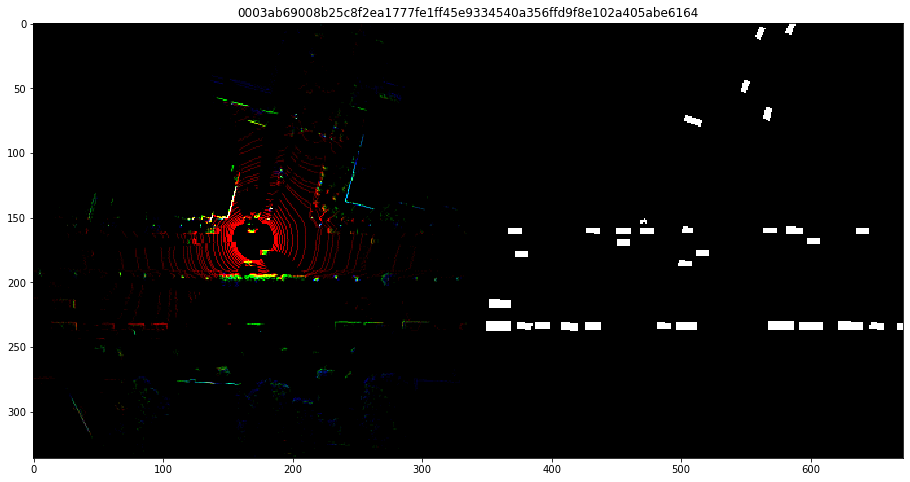

In [2]:
class BEVImageDataset(torch.utils.data.Dataset):
    def __init__(self, input_filepaths, target_filepaths, map_filepaths=None):
        self.input_filepaths = input_filepaths
        self.target_filepaths = target_filepaths
        self.map_filepaths = map_filepaths
        
        if map_filepaths is not None:
            assert len(input_filepaths) == len(map_filepaths)
        
        assert len(input_filepaths) == len(target_filepaths)

    def __len__(self):
        return len(self.input_filepaths)

    def __getitem__(self, idx):
        input_filepath = self.input_filepaths[idx]
        target_filepath = self.target_filepaths[idx]
        
        sample_token = input_filepath.split("/")[-1].replace("_input.png","")
        
        im = cv2.imread(input_filepath, cv2.IMREAD_UNCHANGED)
        
        if self.map_filepaths:
            map_filepath = self.map_filepaths[idx]
            map_im = cv2.imread(map_filepath, cv2.IMREAD_UNCHANGED)
            im = np.concatenate((im, map_im), axis=2)
        
        target = cv2.imread(target_filepath, cv2.IMREAD_UNCHANGED)
        
        im = im.astype(np.float32)/255
        target = target.astype(np.int64)
        
        im = torch.from_numpy(im.transpose(2,0,1))
        target = torch.from_numpy(target)
        
        return im, target, sample_token

input_filepaths = sorted(glob.glob(os.path.join(train_data_folder, "*_input.png")))
target_filepaths = sorted(glob.glob(os.path.join(train_data_folder, "*_target.png")))

train_dataset = BEVImageDataset(input_filepaths, target_filepaths)
    
im, target, sample_token = train_dataset[1]
im = im.numpy()
target = target.numpy()

plt.figure(figsize=(16,8))

target_as_rgb = np.repeat(target[...,None], 3, 2)
# Transpose the input volume CXY to XYC order, which is what matplotlib requires.
plt.imshow(np.hstack((im.transpose(1,2,0)[...,:3], target_as_rgb)))
plt.title(sample_token)
plt.show()


In [3]:
# This implementation was copied from https://github.com/jvanvugt/pytorch-unet, it is MIT licensed.

class UNet(nn.Module):
    def __init__(
        self,
        in_channels=1,
        n_classes=2,
        depth=5,
        wf=6,
        padding=False,
        batch_norm=False,
        up_mode='upconv',
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

In [4]:
def get_unet_model(in_channels=3, num_output_classes=2):
    model = UNet(in_channels=in_channels, n_classes=num_output_classes, wf=5, depth=4, padding=True, up_mode='upsample')
    
    # Optional, for multi GPU training and inference
    model = nn.DataParallel(model)
    return model



In [5]:
def visualize_predictions(input_image, prediction, target, n_images=2, apply_softmax=True):
    """
    Takes as input 3 PyTorch tensors, plots the input image, predictions and targets.
    """
    # Only select the first n images
    prediction = prediction[:n_images]
    target = target[:n_images]
    input_image = input_image[:n_images]

    prediction = prediction.detach().cpu().numpy()
    if apply_softmax:
        prediction = scipy.special.softmax(prediction, axis=1)
    class_one_preds = np.hstack(1-prediction[:,0])

    target = np.hstack(target.detach().cpu().numpy())

    class_rgb = np.repeat(class_one_preds[..., None], 3, axis=2)
    class_rgb[...,2] = 0
    class_rgb[...,1] = target

    
    input_im = np.hstack(input_image.cpu().numpy().transpose(0,2,3,1))
    
    if input_im.shape[2] == 3:
        input_im_grayscale = np.repeat(input_im.mean(axis=2)[..., None], 3, axis=2)
        overlayed_im = (input_im_grayscale*0.6 + class_rgb*0.7).clip(0,1)
    else:
        input_map = input_im[...,3:]
        overlayed_im = (input_map*0.6 + class_rgb*0.7).clip(0,1)

    thresholded_pred = np.repeat(class_one_preds[..., None] > 0.5, 3, axis=2)

    fig = plt.figure(figsize=(12,26))
    plot_im = np.vstack([class_rgb, input_im[...,:3], overlayed_im, thresholded_pred]).clip(0,1).astype(np.float32)
    plt.imshow(plot_im)
    plt.axis("off")
    plt.show()

In [6]:
# We weigh the loss for the 0 class lower to account for (some of) the big class imbalance.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights = torch.from_numpy(np.array([0.2] + [1.0]*len(classes), dtype=np.float32))
class_weights = class_weights.to(device)

In [7]:
batch_size = 8
epochs = 15 # Note: We may be able to train for longer and expect better results, the reason this number is low is to keep the runtime short.

model = get_unet_model(num_output_classes=len(classes)+1)
model = model.to(device)

optim = torch.optim.Adam(model.parameters(), lr=1e-3)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count()*2)

all_losses = []

for epoch in range(1, epochs+1):
    print("Epoch", epoch)
    
    epoch_losses = []
    progress_bar = tqdm_notebook(dataloader)
    
    for ii, (X, target, sample_ids) in enumerate(progress_bar):
        X = X.to(device)  # [N, 3, H, W]
        target = target.to(device)  # [N, H, W] with class indices (0, 1)
        prediction = model(X)  # [N, 2, H, W]
        loss = F.cross_entropy(prediction, target, weight=class_weights)

        optim.zero_grad()
        loss.backward()
        optim.step()
        
        epoch_losses.append(loss.detach().cpu().numpy())

        if ii == 0:
            visualize_predictions(X, prediction, target)
    
    print("Loss:", np.mean(epoch_losses))
    all_losses.extend(epoch_losses)
    
    checkpoint_filename = "unet_checkpoint_epoch_{}.pth".format(epoch)
    checkpoint_filepath = os.path.join(ARTIFACTS_FOLDER, checkpoint_filename)
    torch.save(model.state_dict(), checkpoint_filepath)
    
plt.figure(figsize=(12,12))
plt.plot(all_losses, alpha=0.75)
plt.show()

Epoch 1


/home/vignesh/anaconda3/envs/deepnet/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


RuntimeError: CUDA out of memory. Tried to allocate 112.00 MiB (GPU 0; 3.95 GiB total capacity; 2.47 GiB already allocated; 59.44 MiB free; 132.62 MiB cached)